## Purpose
The purpose of this notebook to train a K-Means clustering algorithm to classify paralyzed vs non-paralyzed vocal cords from ultrasound images.<br>

0 - not paralyzed
1 - paralyzed

This cell contains the imports needed for the program.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from PIL import Image
import os
from tqdm import tqdm
import csv
from IPython.display import clear_output
import matplotlib.pyplot as plt

This cell creates a folder to save the models.

In [2]:
try:
    if not os.path.exists('models'):
        os.makedirs('models')
except OSError:
    print('Error creating data directory.')

Image filename meanings:
- Healthy - regular healthy images of vocal cords
- Healthy2 - split in half, and blended back together images of healthy vocal cords, hopefully helps alleviate a potential mdodel issue with artifacts in the synthetic images.
- Leftpar - synthetic image, with the left side of the image stretched 50% vertically, right side is original image. 
- Rightpar - synthetic image, with the right side of the image stretched 50% vertically, left side is original image.

Defining a dataset class for our specific images.

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir  # Store image directory path
        self.transform = transform

        # List all image files in the directory
        self.img_labels = []
        print(f"Looking in directory: {img_dir}")

        # Check if directory exists
        if not os.path.exists(img_dir):
            raise FileNotFoundError(f"Directory {img_dir} not found")

        for file_name in os.listdir(img_dir):
            # Debugging: print file names to see what's being processed
            print(f"Found file: {file_name}")
            
            # Check if it's a .png file
            if file_name.endswith('.png'):  
                label = None
                if 'healthy' in file_name.lower():
                    label = 0  # Healthy
                elif 'healthy2' in file_name.lower():
                    label = 0  # Healthy (modified)
                elif 'leftpar' in file_name.lower():
                    label = 1  # Left vocal cord paralysis
                elif 'rightpar' in file_name.lower():
                    label = 1  # Right vocal cord paralysis

                if label is not None:
                    self.img_labels.append((file_name, label))
                else:
                    print(f"Skipping unknown file: {file_name}")
                
        # Debugging: print number of labels found
        print(f"Found {len(self.img_labels)} .png files in the directory")

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels[idx][0])
        image = Image.open(img_path)  # Load the .png file using PIL
        
        if self.transform:
            image = self.transform(image)
        
        label = self.img_labels[idx][1]  # Extract label (0 for healthy, 1 for paralysis)
        file_name = self.img_labels[idx][0]  # Extract file name
        
        return image, label, file_name

In [12]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to 256x256
    transforms.Grayscale(num_output_channels=1),  # Ensure single grayscale channel
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize for grayscale images
])

Create the dataset.

In [13]:
# Create dataset
img_dir = '/data/ai_club/team_13_2024-25/VIPR/Data/training_images'
dataset = CustomDataset(img_dir=img_dir, transform=transform)

Looking in directory: /data/ai_club/team_13_2024-25/VIPR/Data/training_images
Found file: leftpar_9961.wmv_frame960.png
Found file: leftpar_9961.wmv_frame960_aug0.png
Found file: leftpar_9961.wmv_frame960_aug1.png
Found file: leftpar_9961.wmv_frame960_aug2.png
Found file: leftpar_9961.wmv_frame960_aug3.png
Found file: leftpar_9961.wmv_frame960_aug4.png
Found file: leftpar_9961.wmv_frame960_aug5.png
Found file: leftpar_9961.wmv_frame960_aug6.png
Found file: rightpar_9961.wmv_frame960.png
Found file: rightpar_9961.wmv_frame960_aug0.png
Found file: rightpar_9961.wmv_frame960_aug1.png
Found file: rightpar_9961.wmv_frame960_aug2.png
Found file: rightpar_9961.wmv_frame960_aug3.png
Found file: rightpar_9961.wmv_frame960_aug4.png
Found file: rightpar_9961.wmv_frame960_aug5.png
Found file: rightpar_9961.wmv_frame960_aug6.png
Found file: healthy_9961.wmv_frame960.png
Found file: healthy_9961.wmv_frame960_aug0.png
Found file: healthy_9961.wmv_frame960_aug1.png
Found file: healthy_9961.wmv_frame96

Split the data and create dataloaders.

In [15]:
# Split the dataset into train and validation sets (80%-20% split)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoader for train and validation sets
batch_size = 64  # You can adjust this batch size according to your needs
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [37]:
print(len(dataset))

34816


Setting up the model.

In [24]:
# Define a smaller custom CNN for binary classification
class VIPRnet(nn.Module):
    def __init__(self):
        super(VIPRnet, self).__init__()
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # Grayscale (1 channel)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 32 * 32, 128),  # Adjusted for 256x256 input
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 1),  # Only 1 output neuron for binary classification
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x  # No sigmoid here; use BCEWithLogitsLoss instead

# Model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VIPRnet().to(device)

# Loss & optimizer
criterion = nn.BCEWithLogitsLoss()  # For binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(model)  # Display model architecture

VIPRnet(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=131072, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=128, out_features=1, bias=True)
  )
)


Train the model, with optional saving and loading of model checkpoints.

In [17]:
# Choose a checkpoint to load if desired:
load_model = False
saved_checkpoint_name = "VIPRnet-30-0.0776.pth"
checkpoint_path = os.path.join('models' ,saved_checkpoint_name)

# Load existing model if checkpoint exists
if load_model and os.path.exists(checkpoint_path):
    print(f"Loading model from {checkpoint_path}...")
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1  # Continue from next epoch
    print(f"Resuming training from epoch {start_epoch}...")
else:
    print('Starting training from scratch.')
    start_epoch = 0  # Start from scratch
    epoch_data_train = []
    epoch_data_val = []
    train_accuracies = []
    val_accuracies = []


# Set desired number of epochs
num_epochs = 50


model.train() # set model to training mode
for epoch in range(start_epoch,num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    
    # TRAINING PHASE
    total_loss_train = 0
    total_correct_train = 0
    total_examples_train = 0
    batch_count = 0
    
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1} - TRAIN", unit="batch")
    for batch_idx, (inputs, labels, _) in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)  # Ensure shape [batch_size, 1]
        optimizer.zero_grad()

        outputs = model(inputs)

        loss_train = criterion(outputs, labels)
        loss_train.backward()
        optimizer.step()

        total_loss_train += loss_train.item()
        predictions_train = torch.round(torch.sigmoid(outputs))
        
        # Count correct predictions and total examples
        total_correct_train += (predictions_train.squeeze() == labels.squeeze()).sum().item()
        total_examples_train += labels.numel()
        batch_count += 1

    average_loss_train = total_loss_train / batch_count
    average_accuracy_train = total_correct_train / total_examples_train
    print(f"TRAINING | Loss: {average_loss_train:.4f}, Accuracy: {average_accuracy_train:.2%}")
    epoch_data_train.append([epoch+1, average_loss_train, average_accuracy_train])
    train_accuracies.append(average_accuracy_train)
    
    # VALIDATION PHASE
    model.eval()
    total_loss_val = 0
    total_correct_val = 0
    total_examples_val = 0
    batch_count = 0
    
    progress_bar_val = tqdm(enumerate(val_loader), total=len(val_loader), desc="VAL", unit="batch")
    for batch_idx, (inputs, labels, _) in progress_bar_val:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)

        loss_val = criterion(outputs.squeeze(), labels.float().squeeze())
        total_loss_val += loss_val.item()
        
        predictions_val = torch.round(torch.sigmoid(outputs))
        total_correct_val += (predictions_val.squeeze() == labels.squeeze()).sum().item()
        total_examples_val += labels.numel()
        batch_count += 1
        
    average_loss_val = total_loss_val / batch_count
    average_accuracy_val = total_correct_val / total_examples_val
    print(f"VALIDATION | Loss: {average_loss_val:.4f}, Accuracy: {average_accuracy_val:.2%}")
    epoch_data_val.append([epoch+1, average_loss_val, average_accuracy_val])
    val_accuracies.append(average_accuracy_val)
    
    # Optionally save model checkpoint here
    save = True
    checkpoint_path = f'models/VIPRnet_V3--B{batch_size}--E{epoch+1}--L{average_loss_train:.4f}.pth'
    
    if save:
        # Save model checkpoint
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': average_loss_train,
            'train_data': epoch_data_train[-1],
            'val_data': epoch_data_val[-1]
        }, checkpoint_path)
        print(f"Model saved to {checkpoint_path}")
    
    # Switch back to train mode for next epoch
    model.train()

Starting training from scratch.
Epoch 1/50


Epoch 1 - TRAIN:  12%|█▏        | 54/436 [00:17<02:04,  3.08batch/s]


KeyboardInterrupt: 

In [18]:
# Check for multiple GPUs and set up DataParallel
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs for training...")
    model = nn.DataParallel(model)  # Wrap model for multi-GPU training

model = model.to(device)

# Choose a checkpoint to load if desired:
load_model = False
saved_checkpoint_name = "VIPRnet-30-0.0776.pth"
checkpoint_path = os.path.join('models', saved_checkpoint_name)

# Load existing model if checkpoint exists
if load_model and os.path.exists(checkpoint_path):
    print(f"Loading model from {checkpoint_path}...")
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1  # Continue from next epoch
    print(f"Resuming training from epoch {start_epoch}...")
else:
    print('Starting training from scratch.')
    start_epoch = 0  # Start from scratch
    epoch_data_train = []
    epoch_data_val = []
    train_accuracies = []
    val_accuracies = []

# Set desired number of epochs
num_epochs = 50

# Training loop
model.train()  # Set model to training mode
for epoch in range(start_epoch, num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    # TRAINING PHASE
    total_loss_train = 0
    total_correct_train = 0
    total_examples_train = 0
    batch_count = 0
    
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1} - TRAIN", unit="batch")
    for batch_idx, (inputs, labels, _) in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)  # Ensure shape [batch_size, 1]

        optimizer.zero_grad()
        outputs = model(inputs)  # Model runs in parallel across all GPUs

        loss_train = criterion(outputs, labels)
        loss_train.backward()
        optimizer.step()

        total_loss_train += loss_train.item()
        predictions_train = torch.round(torch.sigmoid(outputs))
        
        # Count correct predictions and total examples
        total_correct_train += (predictions_train.squeeze() == labels.squeeze()).sum().item()
        total_examples_train += labels.numel()
        batch_count += 1

    average_loss_train = total_loss_train / batch_count
    average_accuracy_train = total_correct_train / total_examples_train
    print(f"TRAINING | Loss: {average_loss_train:.4f}, Accuracy: {average_accuracy_train:.2%}")
    epoch_data_train.append([epoch+1, average_loss_train, average_accuracy_train])
    train_accuracies.append(average_accuracy_train)

    # VALIDATION PHASE
    model.eval()  # Switch to evaluation mode
    total_loss_val = 0
    total_correct_val = 0
    total_examples_val = 0
    batch_count = 0

    progress_bar_val = tqdm(enumerate(val_loader), total=len(val_loader), desc="VAL", unit="batch")
    with torch.no_grad():  # No gradients for validation
        for batch_idx, (inputs, labels, _) in progress_bar_val:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)

            loss_val = criterion(outputs.squeeze(), labels.float().squeeze())
            total_loss_val += loss_val.item()

            predictions_val = torch.round(torch.sigmoid(outputs))
            total_correct_val += (predictions_val.squeeze() == labels.squeeze()).sum().item()
            total_examples_val += labels.numel()
            batch_count += 1

    average_loss_val = total_loss_val / batch_count
    average_accuracy_val = total_correct_val / total_examples_val
    print(f"VALIDATION | Loss: {average_loss_val:.4f}, Accuracy: {average_accuracy_val:.2%}")
    epoch_data_val.append([epoch+1, average_loss_val, average_accuracy_val])
    val_accuracies.append(average_accuracy_val)

    # Optionally save model checkpoint
    save = True
    checkpoint_path = f'models/VIPRnet_V3--B{batch_size}--E{epoch+1}--L{average_loss_train:.4f}.pth'

    if save:
        # Save model checkpoint - use .module when using DataParallel
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.module.state_dict() if isinstance(model, nn.DataParallel) else model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': average_loss_train,
            'train_data': epoch_data_train[-1],
            'val_data': epoch_data_val[-1]
        }, checkpoint_path)
        print(f"Model saved to {checkpoint_path}")

    # Switch back to train mode for next epoch
    model.train()

Using 4 GPUs for training...
Starting training from scratch.
Epoch 1/50


Epoch 1 - TRAIN: 100%|██████████| 436/436 [01:52<00:00,  3.89batch/s]


TRAINING | Loss: 0.6444, Accuracy: 62.05%


VAL: 100%|██████████| 109/109 [00:22<00:00,  4.85batch/s]


VALIDATION | Loss: 0.6049, Accuracy: 66.74%
Model saved to models/VIPRnet_V3--B64--E1--L0.6444.pth
Epoch 2/50


Epoch 2 - TRAIN: 100%|██████████| 436/436 [01:45<00:00,  4.12batch/s]


TRAINING | Loss: 0.5879, Accuracy: 67.72%


VAL: 100%|██████████| 109/109 [00:21<00:00,  4.98batch/s]


VALIDATION | Loss: 0.5467, Accuracy: 70.69%
Model saved to models/VIPRnet_V3--B64--E2--L0.5879.pth
Epoch 3/50


Epoch 3 - TRAIN: 100%|██████████| 436/436 [01:49<00:00,  4.00batch/s]


TRAINING | Loss: 0.5386, Accuracy: 71.74%


VAL: 100%|██████████| 109/109 [00:21<00:00,  5.01batch/s]


VALIDATION | Loss: 0.4977, Accuracy: 74.07%
Model saved to models/VIPRnet_V3--B64--E3--L0.5386.pth
Epoch 4/50


Epoch 4 - TRAIN: 100%|██████████| 436/436 [01:46<00:00,  4.11batch/s]


TRAINING | Loss: 0.4856, Accuracy: 75.45%


VAL: 100%|██████████| 109/109 [00:21<00:00,  5.13batch/s]


VALIDATION | Loss: 0.4561, Accuracy: 78.17%
Model saved to models/VIPRnet_V3--B64--E4--L0.4856.pth
Epoch 5/50


Epoch 5 - TRAIN: 100%|██████████| 436/436 [01:46<00:00,  4.10batch/s]


TRAINING | Loss: 0.4309, Accuracy: 78.79%


VAL: 100%|██████████| 109/109 [00:21<00:00,  5.14batch/s]


VALIDATION | Loss: 0.4180, Accuracy: 80.24%
Model saved to models/VIPRnet_V3--B64--E5--L0.4309.pth
Epoch 6/50


Epoch 6 - TRAIN: 100%|██████████| 436/436 [01:49<00:00,  4.00batch/s]


TRAINING | Loss: 0.3866, Accuracy: 81.37%


VAL: 100%|██████████| 109/109 [00:22<00:00,  4.92batch/s]


VALIDATION | Loss: 0.3858, Accuracy: 82.17%
Model saved to models/VIPRnet_V3--B64--E6--L0.3866.pth
Epoch 7/50


Epoch 7 - TRAIN: 100%|██████████| 436/436 [01:46<00:00,  4.11batch/s]


TRAINING | Loss: 0.3300, Accuracy: 84.74%


VAL: 100%|██████████| 109/109 [00:21<00:00,  5.13batch/s]


VALIDATION | Loss: 0.3600, Accuracy: 83.89%
Model saved to models/VIPRnet_V3--B64--E7--L0.3300.pth
Epoch 8/50


Epoch 8 - TRAIN: 100%|██████████| 436/436 [01:45<00:00,  4.12batch/s]


TRAINING | Loss: 0.2867, Accuracy: 86.98%


VAL: 100%|██████████| 109/109 [00:21<00:00,  5.13batch/s]


VALIDATION | Loss: 0.2946, Accuracy: 87.44%
Model saved to models/VIPRnet_V3--B64--E8--L0.2867.pth
Epoch 9/50


Epoch 9 - TRAIN: 100%|██████████| 436/436 [01:49<00:00,  4.00batch/s]


TRAINING | Loss: 0.2357, Accuracy: 89.71%


VAL: 100%|██████████| 109/109 [00:22<00:00,  4.95batch/s]


VALIDATION | Loss: 0.2563, Accuracy: 89.50%
Model saved to models/VIPRnet_V3--B64--E9--L0.2357.pth
Epoch 10/50


Epoch 10 - TRAIN: 100%|██████████| 436/436 [01:46<00:00,  4.11batch/s]


TRAINING | Loss: 0.1992, Accuracy: 91.70%


VAL: 100%|██████████| 109/109 [00:21<00:00,  5.11batch/s]


VALIDATION | Loss: 0.2033, Accuracy: 91.87%
Model saved to models/VIPRnet_V3--B64--E10--L0.1992.pth
Epoch 11/50


Epoch 11 - TRAIN: 100%|██████████| 436/436 [01:48<00:00,  4.00batch/s]


TRAINING | Loss: 0.1702, Accuracy: 92.98%


VAL: 100%|██████████| 109/109 [00:22<00:00,  4.94batch/s]


VALIDATION | Loss: 0.1747, Accuracy: 93.67%
Model saved to models/VIPRnet_V3--B64--E11--L0.1702.pth
Epoch 12/50


Epoch 12 - TRAIN: 100%|██████████| 436/436 [01:45<00:00,  4.12batch/s]


TRAINING | Loss: 0.1446, Accuracy: 94.42%


VAL: 100%|██████████| 109/109 [00:21<00:00,  5.11batch/s]


VALIDATION | Loss: 0.1897, Accuracy: 93.25%
Model saved to models/VIPRnet_V3--B64--E12--L0.1446.pth
Epoch 13/50


Epoch 13 - TRAIN: 100%|██████████| 436/436 [01:45<00:00,  4.12batch/s]


TRAINING | Loss: 0.1137, Accuracy: 95.80%


VAL: 100%|██████████| 109/109 [00:21<00:00,  5.13batch/s]


VALIDATION | Loss: 0.1476, Accuracy: 94.62%
Model saved to models/VIPRnet_V3--B64--E13--L0.1137.pth
Epoch 14/50


Epoch 14 - TRAIN: 100%|██████████| 436/436 [01:49<00:00,  4.00batch/s]


TRAINING | Loss: 0.1029, Accuracy: 96.26%


VAL: 100%|██████████| 109/109 [00:22<00:00,  4.95batch/s]


VALIDATION | Loss: 0.1115, Accuracy: 96.17%
Model saved to models/VIPRnet_V3--B64--E14--L0.1029.pth
Epoch 15/50


Epoch 15 - TRAIN: 100%|██████████| 436/436 [01:50<00:00,  3.94batch/s]


TRAINING | Loss: 0.0824, Accuracy: 97.01%


VAL: 100%|██████████| 109/109 [00:22<00:00,  4.90batch/s]


VALIDATION | Loss: 0.1590, Accuracy: 95.42%
Model saved to models/VIPRnet_V3--B64--E15--L0.0824.pth
Epoch 16/50


Epoch 16 - TRAIN: 100%|██████████| 436/436 [01:50<00:00,  3.95batch/s]


TRAINING | Loss: 0.0761, Accuracy: 97.25%


VAL: 100%|██████████| 109/109 [00:22<00:00,  4.90batch/s]


VALIDATION | Loss: 0.1044, Accuracy: 96.61%
Model saved to models/VIPRnet_V3--B64--E16--L0.0761.pth
Epoch 17/50


Epoch 17 - TRAIN: 100%|██████████| 436/436 [01:46<00:00,  4.08batch/s]


TRAINING | Loss: 0.0677, Accuracy: 97.58%


VAL: 100%|██████████| 109/109 [00:23<00:00,  4.67batch/s]


VALIDATION | Loss: 0.0791, Accuracy: 97.50%
Model saved to models/VIPRnet_V3--B64--E17--L0.0677.pth
Epoch 18/50


Epoch 18 - TRAIN: 100%|██████████| 436/436 [01:49<00:00,  3.99batch/s]


TRAINING | Loss: 0.0658, Accuracy: 97.81%


VAL: 100%|██████████| 109/109 [00:21<00:00,  5.00batch/s]


VALIDATION | Loss: 0.1110, Accuracy: 96.44%
Model saved to models/VIPRnet_V3--B64--E18--L0.0658.pth
Epoch 19/50


Epoch 19 - TRAIN: 100%|██████████| 436/436 [01:50<00:00,  3.95batch/s]


TRAINING | Loss: 0.0586, Accuracy: 97.98%


VAL: 100%|██████████| 109/109 [00:22<00:00,  4.93batch/s]


VALIDATION | Loss: 0.0669, Accuracy: 98.08%
Model saved to models/VIPRnet_V3--B64--E19--L0.0586.pth
Epoch 20/50


Epoch 20 - TRAIN: 100%|██████████| 436/436 [01:50<00:00,  3.95batch/s]


TRAINING | Loss: 0.0460, Accuracy: 98.40%


VAL: 100%|██████████| 109/109 [00:21<00:00,  5.12batch/s]


VALIDATION | Loss: 0.0809, Accuracy: 97.73%
Model saved to models/VIPRnet_V3--B64--E20--L0.0460.pth
Epoch 21/50


Epoch 21 - TRAIN: 100%|██████████| 436/436 [01:49<00:00,  3.99batch/s]


TRAINING | Loss: 0.0473, Accuracy: 98.43%


VAL: 100%|██████████| 109/109 [00:22<00:00,  4.92batch/s]


VALIDATION | Loss: 0.0808, Accuracy: 97.63%
Model saved to models/VIPRnet_V3--B64--E21--L0.0473.pth
Epoch 22/50


Epoch 22 - TRAIN: 100%|██████████| 436/436 [01:45<00:00,  4.12batch/s]


TRAINING | Loss: 0.0473, Accuracy: 98.52%


VAL: 100%|██████████| 109/109 [00:21<00:00,  5.12batch/s]


VALIDATION | Loss: 0.1164, Accuracy: 96.41%
Model saved to models/VIPRnet_V3--B64--E22--L0.0473.pth
Epoch 23/50


Epoch 23 - TRAIN: 100%|██████████| 436/436 [01:45<00:00,  4.12batch/s]


TRAINING | Loss: 0.0381, Accuracy: 98.76%


VAL: 100%|██████████| 109/109 [00:21<00:00,  5.12batch/s]


VALIDATION | Loss: 0.0530, Accuracy: 98.38%
Model saved to models/VIPRnet_V3--B64--E23--L0.0381.pth
Epoch 24/50


Epoch 24 - TRAIN: 100%|██████████| 436/436 [01:51<00:00,  3.92batch/s]


TRAINING | Loss: 0.0533, Accuracy: 98.22%


VAL: 100%|██████████| 109/109 [00:22<00:00,  4.95batch/s]


VALIDATION | Loss: 0.0673, Accuracy: 98.09%
Model saved to models/VIPRnet_V3--B64--E24--L0.0533.pth
Epoch 25/50


Epoch 25 - TRAIN: 100%|██████████| 436/436 [01:46<00:00,  4.10batch/s]


TRAINING | Loss: 0.0356, Accuracy: 98.82%


VAL: 100%|██████████| 109/109 [00:21<00:00,  5.12batch/s]


VALIDATION | Loss: 0.0493, Accuracy: 98.75%
Model saved to models/VIPRnet_V3--B64--E25--L0.0356.pth
Epoch 26/50


Epoch 26 - TRAIN: 100%|██████████| 436/436 [01:46<00:00,  4.11batch/s]


TRAINING | Loss: 0.0358, Accuracy: 98.96%


VAL: 100%|██████████| 109/109 [00:21<00:00,  5.10batch/s]


VALIDATION | Loss: 0.0471, Accuracy: 98.68%
Model saved to models/VIPRnet_V3--B64--E26--L0.0358.pth
Epoch 27/50


Epoch 27 - TRAIN: 100%|██████████| 436/436 [01:49<00:00,  3.98batch/s]


TRAINING | Loss: 0.0287, Accuracy: 99.15%


VAL: 100%|██████████| 109/109 [00:22<00:00,  4.91batch/s]


VALIDATION | Loss: 0.0632, Accuracy: 98.38%
Model saved to models/VIPRnet_V3--B64--E27--L0.0287.pth
Epoch 28/50


Epoch 28 - TRAIN: 100%|██████████| 436/436 [01:46<00:00,  4.11batch/s]


TRAINING | Loss: 0.0407, Accuracy: 98.78%


VAL: 100%|██████████| 109/109 [00:21<00:00,  5.10batch/s]


VALIDATION | Loss: 0.0722, Accuracy: 97.82%
Model saved to models/VIPRnet_V3--B64--E28--L0.0407.pth
Epoch 29/50


Epoch 29 - TRAIN: 100%|██████████| 436/436 [01:49<00:00,  4.00batch/s]


TRAINING | Loss: 0.0245, Accuracy: 99.25%


VAL: 100%|██████████| 109/109 [00:22<00:00,  4.94batch/s]


VALIDATION | Loss: 0.0365, Accuracy: 99.22%
Model saved to models/VIPRnet_V3--B64--E29--L0.0245.pth
Epoch 30/50


Epoch 30 - TRAIN: 100%|██████████| 436/436 [01:46<00:00,  4.11batch/s]


TRAINING | Loss: 0.0272, Accuracy: 99.21%


VAL: 100%|██████████| 109/109 [00:21<00:00,  5.12batch/s]


VALIDATION | Loss: 0.0471, Accuracy: 98.79%
Model saved to models/VIPRnet_V3--B64--E30--L0.0272.pth
Epoch 31/50


Epoch 31 - TRAIN: 100%|██████████| 436/436 [01:46<00:00,  4.11batch/s]


TRAINING | Loss: 0.0256, Accuracy: 99.20%


VAL: 100%|██████████| 109/109 [00:21<00:00,  5.11batch/s]


VALIDATION | Loss: 0.0370, Accuracy: 99.04%
Model saved to models/VIPRnet_V3--B64--E31--L0.0256.pth
Epoch 32/50


Epoch 32 - TRAIN: 100%|██████████| 436/436 [01:49<00:00,  4.00batch/s]


TRAINING | Loss: 0.0254, Accuracy: 99.18%


VAL: 100%|██████████| 109/109 [00:22<00:00,  4.95batch/s]


VALIDATION | Loss: 0.0426, Accuracy: 98.88%
Model saved to models/VIPRnet_V3--B64--E32--L0.0254.pth
Epoch 33/50


Epoch 33 - TRAIN: 100%|██████████| 436/436 [01:46<00:00,  4.11batch/s]


TRAINING | Loss: 0.0290, Accuracy: 99.15%


VAL: 100%|██████████| 109/109 [00:21<00:00,  5.13batch/s]


VALIDATION | Loss: 0.0416, Accuracy: 98.71%
Model saved to models/VIPRnet_V3--B64--E33--L0.0290.pth
Epoch 34/50


Epoch 34 - TRAIN: 100%|██████████| 436/436 [01:46<00:00,  4.11batch/s]


TRAINING | Loss: 0.0196, Accuracy: 99.42%


VAL: 100%|██████████| 109/109 [00:21<00:00,  5.12batch/s]


VALIDATION | Loss: 0.0367, Accuracy: 99.20%
Model saved to models/VIPRnet_V3--B64--E34--L0.0196.pth
Epoch 35/50


Epoch 35 - TRAIN: 100%|██████████| 436/436 [01:49<00:00,  4.00batch/s]


TRAINING | Loss: 0.0158, Accuracy: 99.52%


VAL: 100%|██████████| 109/109 [00:22<00:00,  4.93batch/s]


VALIDATION | Loss: 0.0356, Accuracy: 99.10%
Model saved to models/VIPRnet_V3--B64--E35--L0.0158.pth
Epoch 36/50


Epoch 36 - TRAIN: 100%|██████████| 436/436 [01:46<00:00,  4.11batch/s]


TRAINING | Loss: 0.0182, Accuracy: 99.47%


VAL: 100%|██████████| 109/109 [00:21<00:00,  5.11batch/s]


VALIDATION | Loss: 0.0402, Accuracy: 99.11%
Model saved to models/VIPRnet_V3--B64--E36--L0.0182.pth
Epoch 37/50


Epoch 37 - TRAIN: 100%|██████████| 436/436 [01:45<00:00,  4.12batch/s]


TRAINING | Loss: 0.0228, Accuracy: 99.35%


VAL: 100%|██████████| 109/109 [00:21<00:00,  5.11batch/s]


VALIDATION | Loss: 0.0470, Accuracy: 98.81%
Model saved to models/VIPRnet_V3--B64--E37--L0.0228.pth
Epoch 38/50


Epoch 38 - TRAIN: 100%|██████████| 436/436 [01:50<00:00,  3.94batch/s]


TRAINING | Loss: 0.0286, Accuracy: 99.21%


VAL: 100%|██████████| 109/109 [00:22<00:00,  4.75batch/s]


VALIDATION | Loss: 0.0403, Accuracy: 99.04%
Model saved to models/VIPRnet_V3--B64--E38--L0.0286.pth
Epoch 39/50


Epoch 39 - TRAIN: 100%|██████████| 436/436 [01:46<00:00,  4.08batch/s]


TRAINING | Loss: 0.0183, Accuracy: 99.49%


VAL: 100%|██████████| 109/109 [00:22<00:00,  4.95batch/s]


VALIDATION | Loss: 0.0433, Accuracy: 98.95%
Model saved to models/VIPRnet_V3--B64--E39--L0.0183.pth
Epoch 40/50


Epoch 40 - TRAIN: 100%|██████████| 436/436 [01:50<00:00,  3.95batch/s]


TRAINING | Loss: 0.0173, Accuracy: 99.48%


VAL: 100%|██████████| 109/109 [00:22<00:00,  4.84batch/s]


VALIDATION | Loss: 0.0312, Accuracy: 99.28%
Model saved to models/VIPRnet_V3--B64--E40--L0.0173.pth
Epoch 41/50


Epoch 41 - TRAIN: 100%|██████████| 436/436 [01:46<00:00,  4.08batch/s]


TRAINING | Loss: 0.0187, Accuracy: 99.49%


VAL: 100%|██████████| 109/109 [00:21<00:00,  4.97batch/s]


VALIDATION | Loss: 0.0298, Accuracy: 99.25%
Model saved to models/VIPRnet_V3--B64--E41--L0.0187.pth
Epoch 42/50


Epoch 42 - TRAIN: 100%|██████████| 436/436 [01:46<00:00,  4.11batch/s]


TRAINING | Loss: 0.0180, Accuracy: 99.54%


VAL: 100%|██████████| 109/109 [00:21<00:00,  5.00batch/s]


VALIDATION | Loss: 0.0351, Accuracy: 99.14%
Model saved to models/VIPRnet_V3--B64--E42--L0.0180.pth
Epoch 43/50


Epoch 43 - TRAIN: 100%|██████████| 436/436 [01:50<00:00,  3.96batch/s]


TRAINING | Loss: 0.0200, Accuracy: 99.43%


VAL: 100%|██████████| 109/109 [00:22<00:00,  4.83batch/s]


VALIDATION | Loss: 0.0420, Accuracy: 99.30%
Model saved to models/VIPRnet_V3--B64--E43--L0.0200.pth
Epoch 44/50


Epoch 44 - TRAIN: 100%|██████████| 436/436 [01:46<00:00,  4.09batch/s]


TRAINING | Loss: 0.0184, Accuracy: 99.46%


VAL: 100%|██████████| 109/109 [00:21<00:00,  5.12batch/s]


VALIDATION | Loss: 0.0495, Accuracy: 98.88%
Model saved to models/VIPRnet_V3--B64--E44--L0.0184.pth
Epoch 45/50


Epoch 45 - TRAIN: 100%|██████████| 436/436 [01:47<00:00,  4.04batch/s]


TRAINING | Loss: 0.0172, Accuracy: 99.50%


VAL: 100%|██████████| 109/109 [00:21<00:00,  5.10batch/s]


VALIDATION | Loss: 0.0267, Accuracy: 99.31%
Model saved to models/VIPRnet_V3--B64--E45--L0.0172.pth
Epoch 46/50


Epoch 46 - TRAIN: 100%|██████████| 436/436 [01:49<00:00,  3.98batch/s]


TRAINING | Loss: 0.0183, Accuracy: 99.45%


VAL: 100%|██████████| 109/109 [00:22<00:00,  4.87batch/s]


VALIDATION | Loss: 0.0346, Accuracy: 98.99%
Model saved to models/VIPRnet_V3--B64--E46--L0.0183.pth
Epoch 47/50


Epoch 47 - TRAIN: 100%|██████████| 436/436 [01:46<00:00,  4.08batch/s]


TRAINING | Loss: 0.0169, Accuracy: 99.56%


VAL: 100%|██████████| 109/109 [00:21<00:00,  4.97batch/s]


VALIDATION | Loss: 0.0411, Accuracy: 98.99%
Model saved to models/VIPRnet_V3--B64--E47--L0.0169.pth
Epoch 48/50


Epoch 48 - TRAIN: 100%|██████████| 436/436 [01:48<00:00,  4.04batch/s]


TRAINING | Loss: 0.0157, Accuracy: 99.55%


VAL: 100%|██████████| 109/109 [00:21<00:00,  5.01batch/s]


VALIDATION | Loss: 0.0391, Accuracy: 99.18%
Model saved to models/VIPRnet_V3--B64--E48--L0.0157.pth
Epoch 49/50


Epoch 49 - TRAIN: 100%|██████████| 436/436 [01:49<00:00,  3.99batch/s]


TRAINING | Loss: 0.0121, Accuracy: 99.67%


VAL: 100%|██████████| 109/109 [00:22<00:00,  4.94batch/s]


VALIDATION | Loss: 0.0470, Accuracy: 98.74%
Model saved to models/VIPRnet_V3--B64--E49--L0.0121.pth
Epoch 50/50


Epoch 50 - TRAIN: 100%|██████████| 436/436 [01:46<00:00,  4.11batch/s]


TRAINING | Loss: 0.0152, Accuracy: 99.58%


VAL: 100%|██████████| 109/109 [00:21<00:00,  5.07batch/s]


VALIDATION | Loss: 0.0273, Accuracy: 99.48%
Model saved to models/VIPRnet_V3--B64--E50--L0.0152.pth


In [151]:
print(train_accuracies)
print(val_accuracies)
print(num_epochs)
num_epochs_list = []
for i in range(epoch_data_train[-1][0]):
    num_epochs_list.append(i + 1)

[0.942002442002442, 0.9532967032967034, 0.9615384615384616, 0.9575702075702076, 0.9627594627594628, 0.9645909645909646, 0.9633699633699634, 0.9627594627594628, 0.9658119658119658]
[0.9609756097560975, 0.9646341463414634, 0.9719512195121951, 0.9646341463414634, 0.9707317073170731, 0.9609756097560975, 0.9719512195121951, 0.9621951219512195, 0.9621951219512195]
50


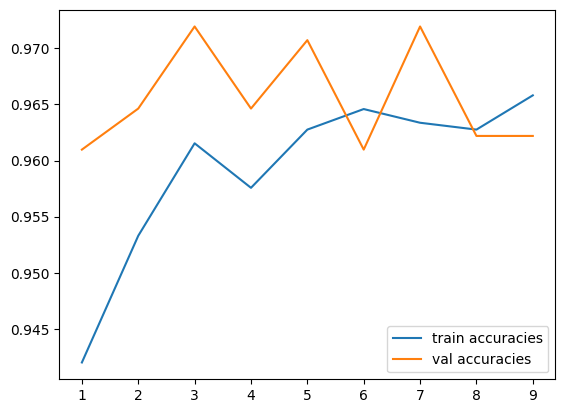

In [152]:
plt.plot(num_epochs_list, train_accuracies, label = 'train accuracies')
plt.plot(num_epochs_list, val_accuracies, label = 'val accuracies')
plt.legend()
plt.show()

## Test that it works with a paralyzed image. Should return 1

In [59]:
# Define the model checkpoint path
model_path = 'VIPRnet-9-0.1489.pth'
model_path = os.path.join('best_models', model_path)

# Load saved checkpoint
checkpoint = torch.load(model_path, map_location=device)  # Ensure it loads on the correct device
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()  # Switch to evaluation mode

# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to 256x256
    transforms.Grayscale(num_output_channels=1),  # Ensure single grayscale channel
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize for grayscale images
])

# Load the image
image_path = "/data/ai_club/team_13_2024-25/VIPR/Data/dr_sebelik_data/Images/Paralyzed/_7 (4).jpg"  # Replace with your image path
image = Image.open(image_path)

# Apply the transformations
image = transform(image).unsqueeze(0)  # Add a batch dimension (since the model expects a batch of images)

# Move the image to the same device as the model (GPU or CPU)
image = image.to(device)

# Make predictions
with torch.no_grad():  # Disable gradient calculation for inference
    outputs = model(image)
    
    # Apply sigmoid to get probabilities, then round to get binary output (0 or 1)
    prediction = torch.round(torch.sigmoid(outputs))

# Print the predicted label
predictions = {0: 'Healthy', 1: 'Paralyzed'}
print(f"Predicted label: {predictions[int(prediction.item())]}")  # 0 or 1 based on your binary classification


Predicted label: Paralyzed


Filename: croppedImage_23.jpg


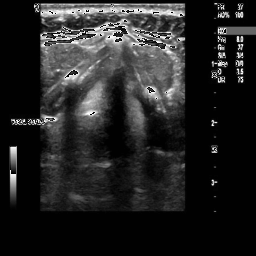

Predicted label: Paralyzed

Filename: _7 (6).jpg


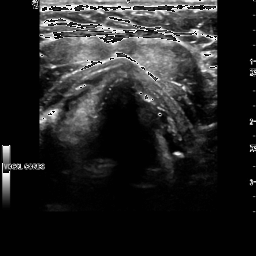

Predicted label: Paralyzed

Filename: _7 (4).jpg


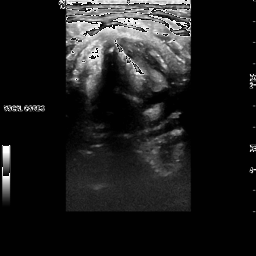

Predicted label: Paralyzed

Filename: vocal_cords_healthy1.png


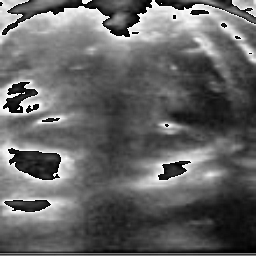

Predicted label: Paralyzed

Filename: vocal_cords_healthy2.png


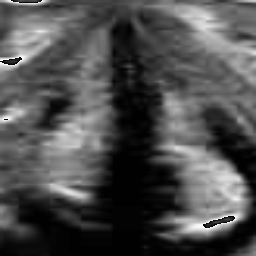

Predicted label: Healthy

Filename: vocal_cords_par3.png


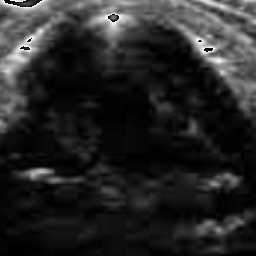

Predicted label: Healthy

Filename: vocal_cords_par4.png


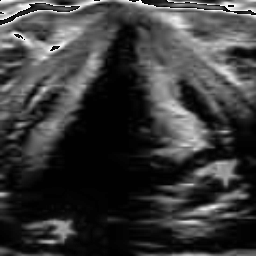

Predicted label: Healthy

Filename: vocal_cords_par74.png


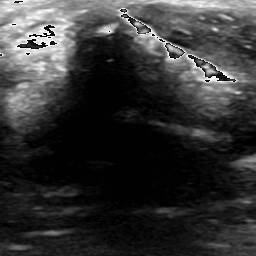

Predicted label: Healthy

Filename: vocal_cords_par76.png


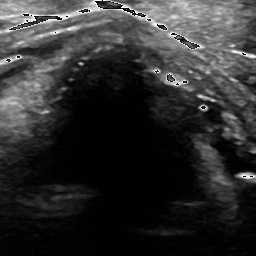

Predicted label: Healthy



In [25]:
# Define the model checkpoint path
model_path = 'VIPRnet_V3--B64--E50--L0.0152.pth'
model_path = os.path.join('models', model_path)

# Load saved checkpoint
checkpoint = torch.load(model_path, map_location=device)  # Ensure it loads on the correct device
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()  # Switch to evaluation mode

# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to 256x256
    transforms.Grayscale(num_output_channels=1),  # Ensure single grayscale channel
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize for grayscale images
])

# Load the image
image_folder = "/data/ai_club/team_13_2024-25/VIPR/Data/dr_sebelik_data/Images/Paralyzed/"  # Replace with your image folder path
image_list = os.listdir(image_folder)
for idx in range(len(image_list)):
    image = Image.open(os.path.join(image_folder,image_list[idx]))
    print('Filename:', image_list[idx])

    # Apply the transformations
    image = transform(image)
    sample_image = transforms.ToPILImage()(image)
    sample_image.show()
    image = image.unsqueeze(0)  # Add a batch dimension (since the model expects a batch of images)

    # Move the image to the same device as the model (GPU or CPU)
    image = image.to(device)

    # Make predictions
    with torch.no_grad():  # Disable gradient calculation for inference
        outputs = model(image)

        # Apply sigmoid to get probabilities, then round to get binary output (0 or 1)
        prediction = torch.round(torch.sigmoid(outputs))

    # Print the predicted label
    predictions = {0: 'Healthy', 1: 'Paralyzed'}
    print(f"Predicted label: {predictions[int(prediction.item())]}\n")  # 0 or 1 based on your binary classification


Get training graphs from folders of checkpoints

In [5]:
def find_balanced_peak_index(list1, list2, weight1=0.5, weight2=0.5):
    """
    Finds the index where the values in both lists are highest in a balanced manner.

    :param list1: First list of numerical values.
    :param list2: Second list of numerical values.
    :param weight1: Weight for the first list in the balancing formula.
    :param weight2: Weight for the second list in the balancing formula.
    :return: The index of the maximum balanced value.
    """
    if len(list1) != len(list2):
        raise ValueError("Both lists must be of the same length.")

    # Compute the balanced score for each index
    balanced_scores = [(weight1 * list1[i] + weight2 * list2[i]) for i in range(len(list1))]

    # Find the index of the maximum balanced score
    max_index = balanced_scores.index(max(balanced_scores))

    return max_index

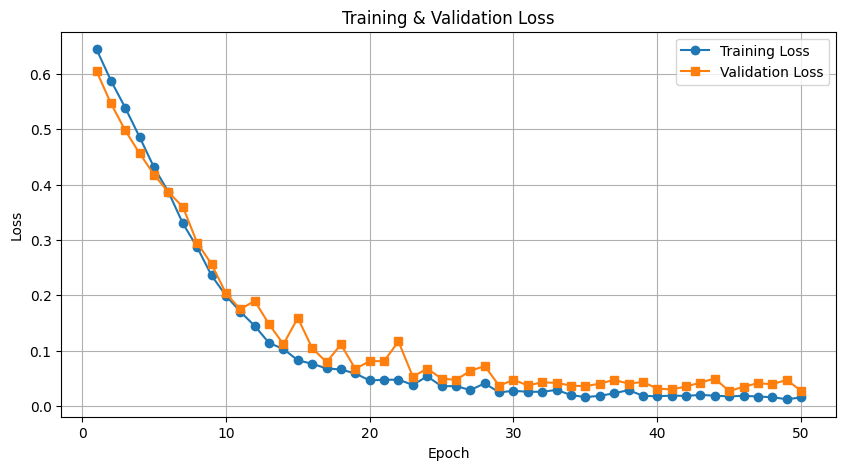

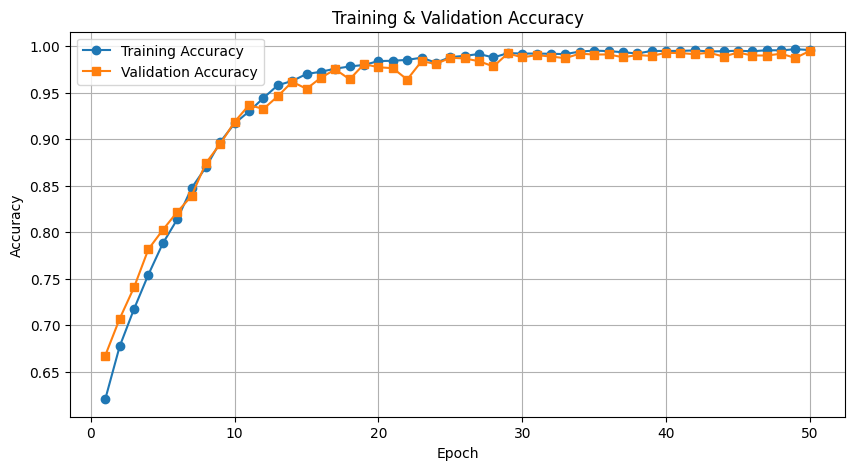

Highest scoring model is from epoch 50. Path: VIPRnet_V3--B64--E50--L0.0152.pth


In [21]:
# Define checkpoint folder
checkpoint_folder = 'models'
checklist = os.listdir(checkpoint_folder)

# Extract data from saved checkpoints
epochs = []
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
for checkpoint_path in checklist:
    if checkpoint_path == '.ipynb_checkpoints':
        continue  # skip checkpoints
    checkpoint = torch.load(os.path.join(checkpoint_folder,checkpoint_path), map_location=torch.device('cpu'))
    epochs.append(checkpoint['epoch'] + 1)
#     train_losses.append(float((checkpoint_path.split('--')[-1])[1:-4]))
    train_losses.append(checkpoint['train_data'][1])
    train_accuracies.append(checkpoint['train_data'][2])
    val_losses.append(checkpoint['val_data'][1])
    val_accuracies.append(checkpoint['val_data'][2])
    
# Convert lists to numpy arrays and sort
epochs = np.array(epochs)
train_losses = np.array(train_losses)
train_accuracies = np.array(train_accuracies)
val_losses = np.array(val_losses)
val_accuracies = np.array(val_accuracies)

# Sort all by epoch number
sorted_indices = np.argsort(epochs)
epochs = epochs[sorted_indices]
train_losses = train_losses[sorted_indices]
train_accuracies = train_accuracies[sorted_indices]
val_losses = val_losses[sorted_indices]
val_accuracies = val_accuracies[sorted_indices]

# Plot Training & Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid()
plt.show()

# Plot Training & Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracies, label='Training Accuracy', marker='o')
plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

highest_accuracy_idx = find_balanced_peak_index(list(train_accuracies), list(val_accuracies))
best_model = checklist[highest_accuracy_idx]
print(f'Highest scoring model is from epoch {epochs[highest_accuracy_idx]}. Path: {checklist[highest_accuracy_idx]}')